In [1]:
# убеждаемся, что используем видеокарту
!nvidia-smi

Sat Mar 13 19:50:24 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.56       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
 # Этим блоком будем визуализировать
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
import scipy
 
# Библиотеки Pytorch
import torch 
import torchvision # здесь лежит mnist, cifar и много других датасетов и трансформаций для картинок
import torch.nn as nn # здесь лежат все слои
import torch.utils.data as data # работа с загрузчиком данных
import torchvision.transforms as transforms
import torchvision.datasets as dsets #работа с классом Датасет
from torch.autograd import Variable # для автоматического дифференциатора
import cv2
# Визуализации графа
from torch.utils.tensorboard import SummaryWriter 
import datetime,os
import time
 
import seaborn as sns
sns.set_style('darkgrid')

In [3]:
# подключаем Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Загружаем 10 картинок
PATH = '/content/drive/MyDrive/datasets/images/pict_1/'
# !ls '/content/drive/My Drive/datasets/images/pict_1/'

list_id = sorted(os.listdir(PATH))
labels = [0, 1, 1, 0, 0, 1, 1, 0, 0, 1]
print(list_id)

['1.png', '10.png', '2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']


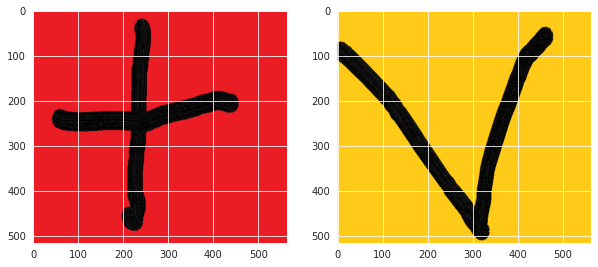

In [5]:
# Примеры изображений
img_1 = Image.open(PATH + list_id[0])
img_2 = Image.open(PATH + list_id[1])

fig, ax = plt.subplots(1, 2, figsize=(10, 6))
ax[0].imshow(img_1)
ax[1].imshow(img_2)
plt.show()

In [6]:
# Класс для работы с датасетом
class GetDataset(data.Dataset):

  def __init__(self, list_id, labels, PATH, transforms=None):
    self.list_id = list_id
    self.labels = labels
    self.transforms = transforms
    self.PATH = PATH

    print(self.list_id)
    print(self.labels)

  def __getitem__(self, index):
    id = self.list_id[index]
    image = cv2.imread(PATH + id)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    if self.transforms:
      image = self.transforms(image)

    x_train = image
    y_train = self.labels[index]

    return x_train, y_train

  def __len__(self):
    return(len(self.list_id))


# Класс модели
class GetModel(nn.Module):
  def __init__(self, input_size, hidden_size, num_classes):
    super().__init__()
    self.layer_1 = nn.Linear(input_size, hidden_size)
    self.relu = nn.ReLU()
    self.layer_2 = nn.Linear(hidden_size, num_classes)
    self.sigmoid = nn.Sigmoid()

  def forward(self, x):
    out = self.layer_1(x)
    out = self.relu(out)
    out = self.layer_2(out)
    out = self.sigmoid(out)
    return out

In [7]:
# преобразуем датасет, как необходимо по заданию
transform = transforms.Compose([
                                transforms.ToTensor(),
                                transforms.Grayscale(),
                                transforms.RandomHorizontalFlip(p=1.0),
                                transforms.Resize((32,32)),
                                transforms.Lambda(lambda x: torch.flatten(x))])


In [8]:
# Информация о датасете
custom_data = GetDataset(list_id[2:], labels[2:], PATH, transform)
len(custom_data)

['2.png', '3.png', '4.png', '5.png', '6.png', '7.png', '8.png', '9.png']
[1, 0, 0, 1, 1, 0, 0, 1]


8

In [9]:
# Создадим dataloader
trainLoader = torch.utils.data.DataLoader(dataset=custom_data,
                                          batch_size=4,
                                          shuffle=True,
                                          num_workers=4)



In [10]:
# Посмотрим на пример генерации
dataiter = iter(trainLoader)
images = dataiter.next()
print(images[0].shape, images[1].shape)
print(images)

torch.Size([4, 1024]) torch.Size([4])
[tensor([[0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572]]), tensor([1, 0, 0, 1])]


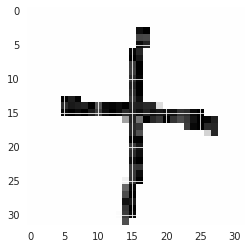

In [11]:
# И на преобразование изображения
test_image = images[0][0].numpy().reshape(32,32)
plt.imshow(test_image, plt.cm.gray)
plt.show()

In [12]:
# объявляем константы
input_size = 1024
num_classes = 1
epochs = 20
learning_rate = 1e-3
hidden_size = 400
class_names = ['cross', 'ok']

# создаём модель
model = GetModel(input_size, hidden_size, num_classes)
print(images[0])
print(model(images[0]))

tensor([[0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572],
        [0.3572, 0.3572, 0.3572,  ..., 0.3572, 0.3572, 0.3572]])
tensor([[0.5050],
        [0.5014],
        [0.4955],
        [0.5023]], grad_fn=<SigmoidBackward>)


In [13]:
# компилируем модель
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
losses = []
model.train()

GetModel(
  (layer_1): Linear(in_features=1024, out_features=400, bias=True)
  (relu): ReLU()
  (layer_2): Linear(in_features=400, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

In [14]:
# # Сохранение и загрузка всей модели
# torch.save(linear, 'model.pkl')
# model = torch.load('model.pkl') # сохраняются даже состояния оптимизатора, результата эпох и т.д.

# # Рекомендуется сохранение только параметров модели (в целях безопасности)
# torch.save(linear.state_dict(), 'params.pkl')
# linear.load_state_dict(torch.load('params.pkl'))

In [15]:
# если есть видеокарта, работаем с моделью на ней
cuda = torch.cuda.is_available()
if cuda:
  model = model.cuda()

Epoch: 1/20, loss: 0.2503884434700012
Epoch: 2/20, loss: 0.1795109659433365
Epoch: 3/20, loss: 0.17319756746292114
Epoch: 4/20, loss: 0.16192995011806488
Epoch: 5/20, loss: 0.1626022309064865
Epoch: 6/20, loss: 0.15047232806682587
Epoch: 7/20, loss: 0.14315353333950043
Epoch: 8/20, loss: 0.13327372074127197
Epoch: 9/20, loss: 0.12908601760864258
Epoch: 10/20, loss: 0.12561163306236267
Epoch: 11/20, loss: 0.1182316467165947
Epoch: 12/20, loss: 0.11160818487405777
Epoch: 13/20, loss: 0.10742589831352234
Epoch: 14/20, loss: 0.10498923808336258
Epoch: 15/20, loss: 0.09964156150817871
Epoch: 16/20, loss: 0.0961410254240036
Epoch: 17/20, loss: 0.09144169092178345
Epoch: 18/20, loss: 0.08560439944267273
Epoch: 19/20, loss: 0.08193282783031464
Epoch: 20/20, loss: 0.08111101388931274


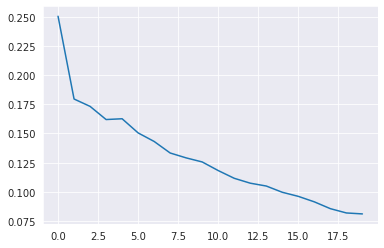

In [16]:
# обучаем модель
for epoch in range(epochs):
  lossTot = 0

  for i, (images, labels) in enumerate(trainLoader):
    labels = labels.view(-1,1).type(torch.FloatTensor)
    images = images.cuda()
    labels = labels.cuda()
    optimizer.zero_grad()
    outputs = model(images)
    loss = criterion(outputs, labels)
    loss.backward()

    lossTot += loss.detach().data

    optimizer.step()

  losses.append(lossTot/len(custom_data))
  print(f'Epoch: {epoch+1}/{epochs}, loss: {losses[-1]}')

plt.plot(losses)
plt.show()

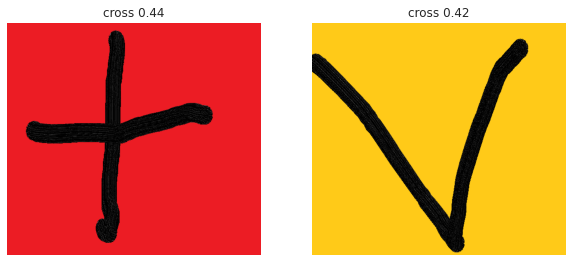

In [17]:
# проверяем работу модели
model.eval()

fig, ax = plt.subplots(1,2, figsize=(10,5))

for i, id in enumerate(list_id[:2]):
  test_image = cv2.cvtColor(cv2.imread(PATH + id), cv2.COLOR_BGR2RGB)
  test_image_for_predict = transform(test_image)
  test_image_for_predict = test_image_for_predict.cuda()
  prediction = model(test_image_for_predict).cpu().detach().numpy()[0]
  ax[i].imshow(test_image)
  ax[i].axis('off')
  ax[i].title.set_text(class_names[int(round(prediction))] + ' ' + str(round(prediction, 2)))

plt.show()